In [1]:
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import constraint as cn

from operator import itemgetter

from graphs import *


In [2]:
node_data = {
    "room_names" : ["entrance", "rest_space", "dining_space", "platform"],
    "length" : [3,3,3,1],
    "width" : [3,3,3,1],
    "height" : [3,3,3,2],
    "lev_height" : [0,0,1,1]
}

In [3]:
node_data

{'room_names': ['entrance', 'rest_space', 'dining_space', 'platform'],
 'length': [3, 3, 3, 1],
 'width': [3, 3, 3, 1],
 'height': [3, 3, 3, 2],
 'lev_height': [0, 0, 1, 1]}

In [8]:
R = np.vectorize(lambda x: SpatialRel(x))(np.array([
    [0, 1, 1, 3],
    [1,0,2,1],
    [1,2,0,1],
    [4,1,1,0]
]))

O = np.vectorize(lambda x: Orient(x))(np.array([
    [0, 1, 0, 0],
    [2, 0, 0, 0],
    np.zeros(4, np.int8),
    np.zeros(4, np.int8)
]))
O

array([[<Orient.NONE: 0>, <Orient.NORTH: 1>, <Orient.NONE: 0>,
        <Orient.NONE: 0>],
       [<Orient.SOUTH: 2>, <Orient.NONE: 0>, <Orient.NONE: 0>,
        <Orient.NONE: 0>],
       [<Orient.NONE: 0>, <Orient.NONE: 0>, <Orient.NONE: 0>,
        <Orient.NONE: 0>],
       [<Orient.NONE: 0>, <Orient.NONE: 0>, <Orient.NONE: 0>,
        <Orient.NONE: 0>]], dtype=object)

In [4]:
CG = nx.complete_graph(4)     

In [5]:
for key, value in node_data.items():
    for nd, item in zip(CG.nodes,value):
        CG.nodes[nd][key] = item

In [6]:
# all nodes have the same position to begin 
for nd in CG.nodes:
    CG.nodes[nd]["pos"] = np.zeros(3)
    CG.nodes[nd]["faces"] = NodeFaces()

In [7]:
CG.nodes.data()

NodeDataView({0: {'room_names': 'entrance', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 0, 'pos': array([0., 0., 0.]), 'faces': <graphs.NodeFaces object at 0x11fb08a30>}, 1: {'room_names': 'rest_space', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 0, 'pos': array([0., 0., 0.]), 'faces': <graphs.NodeFaces object at 0x11fb07460>}, 2: {'room_names': 'dining_space', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 1, 'pos': array([0., 0., 0.]), 'faces': <graphs.NodeFaces object at 0x11fb07fa0>}, 3: {'room_names': 'platform', 'length': 1, 'width': 1, 'height': 2, 'lev_height': 1, 'pos': array([0., 0., 0.]), 'faces': <graphs.NodeFaces object at 0x11fb06d60>}})

In [9]:
n = np.linspace(0,3,4)
X2D,Y2D = np.meshgrid(n,n)
attrs = {(x,y): {"space_rel": sr, "orient": o} for x,y,sr,o in zip(Y2D.ravel(),X2D.ravel(), R.ravel(), O.ravel())}
nx.set_edge_attributes(CG, attrs)

In [10]:
CG[0][3]

{'space_rel': <SpatialRel.CONTAINING: 4>, 'orient': <Orient.NONE: 0>}

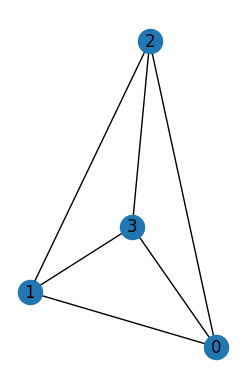

In [11]:
subax1 = plt.subplot(121)
nx.draw(CG, with_labels=True)

In [12]:
# create "spanning" tree
tree = list(nx.edge_dfs(CG, source=0))

In [13]:
CG.edges[tree[1]]

{'space_rel': <SpatialRel.INTERSECTING: 2>, 'orient': <Orient.NONE: 0>}

In [14]:
rng = np.random.default_rng(seed=42)
n_unorient = sum([CG.edges[rel]["orient"] == Orient.NONE for rel in tree])
new_orients = rng.integers(0, 6, len(tree)) # TODO FIX need to have fixed relationships..
new_orients


array([0, 4, 3, 2, 2, 5])

In [15]:
for n, rel in zip(new_orients, tree):
    if CG.edges[rel]["orient"] == Orient.NONE:
        CG.edges[rel]["orient"] = Orient(n)



In [16]:
for n in tree:
    print([n, CG.edges[n]["orient"]])
# TODO organize so that for single unit dif, early numbers come first, until reach last unit. Then  later numbers come first

[(0, 1), <Orient.SOUTH: 2>]
[(1, 2), <Orient.WEST: 4>]
[(2, 0), <Orient.EAST: 3>]
[(0, 3), <Orient.SOUTH: 2>]
[(3, 1), <Orient.SOUTH: 2>]
[(3, 2), <Orient.TOP: 5>]


In [53]:
CG.nodes[1]

{'room_names': 'rest_space',
 'length': 3,
 'width': 3,
 'height': 3,
 'lev_height': 0,
 'pos': array([0., 0., 0.]),
 'faces': {'NORTH': 0,
  'SOUTH': 0,
  'EAST': 0,
  'WEST': 0,
  'TOP': 0,
  'BOTTOM': 0}}

In [ ]:
def set_faces(node):
    # node =CG.nodes[1]
    f = node["faces"]
    f["BOTTOM"]

In [50]:
# FOR testing purposes, match Fig 16a, 3-2 has East(*-1) relationship => West (but edges are unidirectional for now, so keep as East...) 
CG.edges[2,3]["orient"] = Orient.EAST

# OODG

In [18]:
# # go through tree, and assign relationships 
# for n in tree:
#     if n[0] - n[1] == -1: # correct direction -> tree edge
#         print([n, CG.nodes[n[1]]["room_names"]], CG.edges[n]["orient"].vector)
#         CG.nodes[n[1]]["pos"] += CG.edges[n]["orient"].vector
#     elif n[0] -  n[1] == 1: # wrong direction, but consecutive -> tree edge 
#         print([n, CG.nodes[n[0]]["room_names"]], CG.edges[n]["orient"].vector)
#         CG.nodes[n[0]]["pos"] += -1*CG.edges[n]["orient"].vector


        

    
#     # TODO FIX
#     # quick fix, if 2nd node > 1st, and numbers are consecutive multiply vector by -1. ELse pass



[(0, 1), 'rest_space'] [ 0 -1  0]
[(1, 2), 'dining_space'] [-1  0  0]
[(3, 2), 'platform'] [-1  0  0]


In [42]:
# CG.nodes.data()

NodeDataView({0: {'room_names': 'entrance', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 0, 'pos': array([0., 0., 0.])}, 1: {'room_names': 'rest_space', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 0, 'pos': array([ 0., -1.,  0.])}, 2: {'room_names': 'dining_space', 'length': 3, 'width': 3, 'height': 3, 'lev_height': 1, 'pos': array([-1.,  0.,  0.])}, 3: {'room_names': 'platform', 'length': 1, 'width': 1, 'height': 2, 'lev_height': 1, 'pos': array([1., 0., 0.])}})

entrance [0. 0. 0.]
rest_space [ 0. -1.  0.]
dining_space [-1.  0.  0.]
platform [1. 0. 0.]


Text(0.5, 0, 'Z')

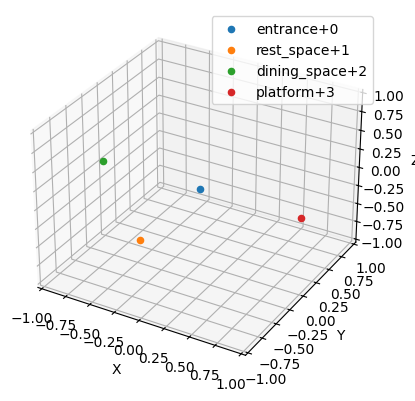

In [47]:
# ax = plt.axes(projection='3d')
# d = {}
# for n in CG.nodes:
#     name, pos = itemgetter("room_names", "pos")(CG.nodes[n])
#     d[name] = pos
#     ax.scatter3D(*pos, label=f"{name}+{n}")
#     print(name, pos)
# # ax.plot3D(d.values())
# ax.legend()
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')


In [19]:
# for n in tree:
#     if n[0] < n[1]: # correct direction 
#         print([n, itemgetter("room_names", "pos")(CG.nodes[n[1]])])

[0, ('entrance', array([0., 0., 0.]))]
[1, ('rest_space', array([ 0., -1.,  0.]))]
[2, ('dining_space', array([-1.,  0.,  0.]))]
[3, ('platform', array([1., 0., 0.]))]


In [50]:
# CG.nodes[0]

{'room_names': 'entrance',
 'length': 3,
 'width': 3,
 'height': 3,
 'lev_height': 0,
 'pos': array([0., 0., 0.])}